In [4]:
# Tested on python 3.8.0 on Macbook Air M1 
%pip install -e . # installs segment-anything 
%pip install numpy torch matplotlib opencv-python-headless torchvision bardapi salesforce-lavis # installs dependencies
# restart kernel

Obtaining file:///Users/adrian/Desktop/cs-projects.nosync/seg-2-bard-caption
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install eva-decord # specific to apple silicon, do not run on other platforms

  Using cached eva_decord-0.6.1-cp38-cp38-macosx_10_9_x86_64.whl (12.9 MB)
Note: you may need to restart the kernel to use updated packages.


# Begin

- Import necessary packages and initialise SAM model and mask generator
- Specify your directory and model type for your SAM model (If you do not have a SAM model, download it [here](https://github.com/facebookresearch/segment-anything#model-checkpoints))

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # since mps does not support all the operations, we need to enable fallback to cpu for some operations

In [2]:
# Import numpy for numerical computation, torch for deep learning, matplotlib for plotting, and OpenCV for image processing
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
from bardapi import Bard
from lavis.models import load_model_and_preprocess

device = "cuda" if torch.cuda.is_available() else "mps"
sam_dir = "/Users/adrian/Desktop/cs-projects.nosync/1-models/sam_vit_b_01ec64.pth" # input the path to your model

sam_checkpoint = sam_dir
model_type = "vit_b" # specify your model type accordingly

# load the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam) # create the generator

/Users/adrian/opt/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Functions

In [7]:
# Define a function to display the segmentations (annotations)
def show_anns(anns):
    # If there are no annotations, return immediately
    if len(anns) == 0:
        return
    
    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    # Set up the plot using Matplotlib
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create an image placeholder with the same shape as the segmentation map
    # The fourth channel is for alpha (transparency)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0  # Set the alpha channel to 0 (transparent)
    
    # For each annotation in the sorted list
    for ann in sorted_anns:
        # Get the segmentation map
        m = ann['segmentation']
        # Create a color mask with random colors and a fixed alpha value
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # Apply the color mask to the segments identified in the image
        img[m] = color_mask
    # Display the image with the colored segmentations
    ax.imshow(img)

# define a function to get the image, and its height and width
def get_image(path):
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    return image, h, w

# define a function to get the mask
def get_mask(img):
    # generate the mask
    masks = mask_generator.generate(img)
    return masks

# define a function to filter the mask based on the area
def filter_mask(mask, h, w):
    # specify the minimum area of the mask
    min_area = 0.02 * h * w
    # create a new dictionary
    new_dict = []

    # filter the masks based on the area
    for i in mask:
        if i['area'] > min_area:
            new_dict.append(i)
    
    return new_dict

def main(img_path, token):
    device = "cuda" if torch.cuda.is_available() else "mps"

    # get the image, and its height and width
    img, h, w = get_image(img_path)

    # get the mask
    masks = get_mask(img)
    # filter the mask based on the area
    new_masks = filter_mask(masks, h, w)
    num_masks = len(new_masks)

    # loads BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset.
    # this also loads the associated image processors
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

    # create a list to store the coordinates and captions
    capt = [[] for _ in range(num_masks)]

    for i in range(len(new_masks)):
        masked_image = img * new_masks[i]['segmentation'][:,:,np.newaxis] + (1 - new_masks[i]['segmentation'][:,:,np.newaxis]) * 255
        masked_image = np.uint8(masked_image)
        masked_image = Image.fromarray(masked_image)    
        masked_image = vis_processors["eval"](masked_image).unsqueeze(0).to(device)

        capt[i].append(new_masks[i]['bbox'])
        capt[i].append(model.generate({"image": masked_image}))

    # full image caption
    full_img = vis_processors["eval"](Image.fromarray(img)).unsqueeze(0).to(device)
    full_img_capt = model.generate({"image": full_img})


    # Initialize an array to hold the sum of all masks
    combined_masks = np.zeros_like(masks[0]['segmentation'])

    # Sum all the masks
    for mask in new_masks:
        combined_masks += mask['segmentation']
    # Normalize to the range 0-255 for image display
    combined_masks_normal = (combined_masks / combined_masks.max() * 255).astype(np.uint8)
    # background caption
    bg = img * combined_masks[:,:,np.newaxis] + (1 - combined_masks[:,:,np.newaxis]) * 255
    bg = np.uint8(bg)
    bg = Image.fromarray(bg)
    bg = vis_processors["eval"](bg).unsqueeze(0).to(device)
    bg_capt = model.generate({"image": bg}) 


    # Construct the string
    string = f"Here is a list of coordinates of segmented areas of interest in an image and it's corresponding descriptions made by another AI.\n{capt}\n\nNext here we have the description of the entire image\n{full_img_capt}\n\nNext  here we have the description of the background (image with the areas of interest  cropped out)\n{bg_capt}\n\nThe size of the image is {w} x {h} \n\nSome of the description may be contradictory due to imperfections in the captioning AI used. Use your own deductions to determine the most likely description of the image."

    # read the image and plot it with axis off
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    bard = Bard(token=token)
    print(bard.get_answer(string)['content']) # get the answer from the bard api

To get Bard token: Visit [Bard](https://bard.google.com/), press F12 to open the console, navigate to Session -> Application -> Cookies, and copy the value of the __Secure-1PSID cookie. This will be your token

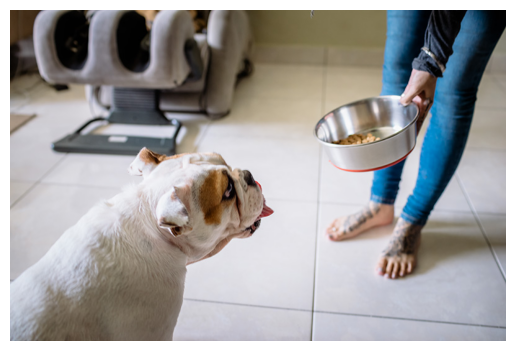

Based on the information you have provided, the most likely description of the image is that it shows a dog eating out of a bowl on the floor. This is supported by the following evidence:

* The description of the entire image is "a dog eating out of a bowl on the floor."
* The description of the background of the image is also "a dog eating out of a bowl on the floor."
* The coordinates of the segmented areas of interest in the image do not include any objects that would contradict this description.
* The size of the image is consistent with a photo of a dog eating out of a bowl on the floor.

It is possible that some of the descriptions of the segmented areas of interest are incorrect. This could be due to imperfections in the captioning AI used. However, the evidence suggests that the overall description of the image is accurate.


In [8]:
img_path = 'test_images/dog.jpg' # insert your image path here
bard_token = 'xxx' # insert your bard token here
main(img_path, bard_token)